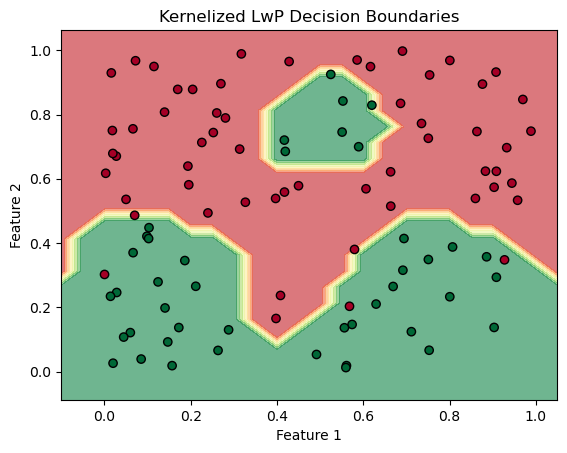

In [ ]:
# CS771 (Autumn 2023)
# Implementation of a kernelized version of the learning with prototypes (nearest class means) classifier
# We will use RBF (Gaussian) kernel but other nonlinear kernels can be tried too
import numpy as np
import matplotlib.pyplot as plt

# Generate a synthetic non-linearly separable dataset

# Data generation functions
def get_data(lower, upper, num, num_dims):
    return np.random.uniform(lower, upper, size=(num, num_dims))

def get_labels(X):
    Y = []
    for x1, x2 in X:
        if x2 < np.sin(10 * x1) / 5 + 0.3 or ((x2 - 0.8) ** 2 + (x1 - 0.5) ** 2) < 0.15 ** 2:
            Y.append(1)
        else:
            Y.append(-1)
    return np.asarray(Y)

# Generate random data and labels
np.random.seed(1)

N = 100
X = get_data(0, 1, N, 2)
y = get_labels(X).reshape(-1)

# Define the Gaussian (RBF) kernel function
def gaussian_kernel(x1, x2, gamma=100):
    return np.exp(-gamma * np.sum((x1 - x2)**2))

# Kernelized Nearest Means Classifier
class Kernelized_LwP:
    def __init__(self, kernel=gaussian_kernel, gamma=1.0):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.X_train = X
        self.y_train = y

    # Unlike LwP with Euclidean distance/similarity, all the action happens at test time (even the class means were not
    # computed beforehand but just we are simply computing the similarity of the test input
    # with the mean of each class
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test))
        for i, x in enumerate(X_test):
            max_similarity = float('-inf')
            for c in self.classes:
                similarity_from_mean = np.sum([self.kernel(x, x_train, self.gamma) for x_train, y_train in zip(self.X_train, self.y_train) if y_train == c])
                if similarity_from_mean > max_similarity:
                    max_similarity = similarity_from_mean
                    y_pred[i] = c
        return y_pred

# Train the kernelized nearest means classifier
# We will be using RBF kernel with gamma = 100 (can play with this value and see how the decision boundary changes)
klwp_classifier = Kernelized_LwP(gamma=100)
klwp_classifier.fit(X, y)

# Create a grid of points for visualization
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predict labels of the grid points
Z = klwp_classifier.predict(grid_points)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries with red and green colors
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlGn, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlGn, edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Kernelized LwP Decision Boundaries')
plt.show()

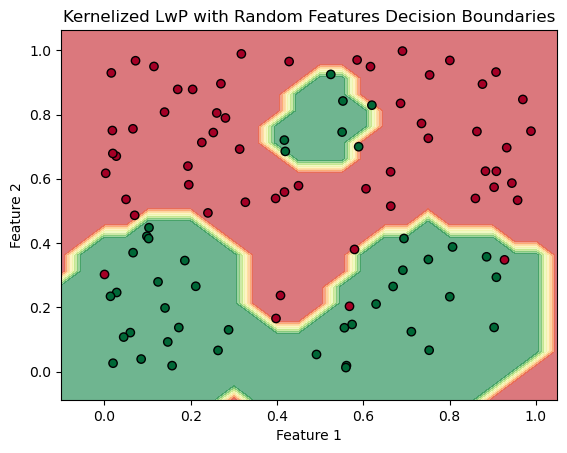

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a synthetic non-linearly separable dataset

# Data generation functions
def get_data(lower, upper, num, num_dims):
    return np.random.uniform(lower, upper, size=(num, num_dims))

def get_labels(X):
    Y = []
    for x1, x2 in X:
        if x2 < np.sin(10 * x1) / 5 + 0.3 or ((x2 - 0.8) ** 2 + (x1 - 0.5) ** 2) < 0.15 ** 2:
            Y.append(1)
        else:
            Y.append(-1)
    return np.asarray(Y)

# Generate random data and labels
np.random.seed(1)

N = 100
X = get_data(0, 1, N, 2)
y = get_labels(X).reshape(-1)

# Define the Gaussian (RBF) kernel function
def rbf_kernel(x1, x2, gamma=100):
    return np.exp(-gamma * np.sum((x1 - x2)**2))

# Approximate the RBF kernel using random features
def approximate_rbf_kernel(X, gamma=100, num_features=1000, random_seed=42):
    np.random.seed(random_seed)
    n_samples, n_features = X.shape
    W = np.random.normal(0, 1 / gamma, size=(n_features, num_features))
    b = np.random.uniform(0, 2 * np.pi, size=num_features)
    features = np.sqrt(2 / num_features) * np.cos(X.dot(W) + b)
    return features

# Compute class centroids in the feature space
def compute_class_centroids(X, y):
    classes = np.unique(y)
    centroids = {}
    for c in classes:
        X_c = X[y == c]
        centroid = np.mean(X_c, axis=0)
        centroids[c] = centroid
    return centroids

# Define a function to compute Euclidean distance with random features
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

# Kernelized Learning with Prototype (LwP) with random features
def kernelized_lwp_random_features(X, y, X_test, gamma=100, num_features=100):
    # Approximate the RBF kernel using random features
    random_features_X = approximate_rbf_kernel(X, gamma, num_features)
    random_features_X_test = approximate_rbf_kernel(X_test, gamma, num_features)

    # Compute class centroids in the feature space
    centroids = compute_class_centroids(random_features_X, y)

    # Predict labels using Euclidean distance with random features
    y_pred = []
    for x_test in random_features_X_test:
        min_distance = float('inf')
        predicted_class = None
        for c, centroid in centroids.items():
            distance = euclidean_distance(x_test, centroid)
            if distance < min_distance:
                min_distance = distance
                predicted_class = c
        y_pred.append(predicted_class)

    return np.array(y_pred)

# Create a grid of points for visualization
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predict labels of the grid points using kernelized LwP
Z = kernelized_lwp_random_features(X, y, grid_points, gamma=0.1, num_features=500)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries with red and green colors
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlGn, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlGn, edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Kernelized LwP with Random Features Decision Boundaries')
plt.show()